In [1]:
from minisom import MiniSom
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_raw = pd.read_csv('kunak_filled.csv', parse_dates=[0], index_col=0).resample('D').mean().drop(columns='PM1 (ug/m3)')
df_raw.head()

,Dew Point (C),H2S (ppb),NO2 (ppb),Humidity (%),O3 (ppb),PM2.5 (ug/m3),PM10 (ug/m3),Temp (C)
Datetime,,,,,,,,
2022-04-10,6.055000,6.988750,52.842917,18.699583,23.745833,4.959583,7.960417,16.300833
2022-04-11,2.193750,0.655833,36.071667,4.787500,48.096250,4.507917,6.797083,13.793750
2022-04-12,3.412917,5.760000,34.426250,17.662500,36.747917,3.970417,6.434167,14.545417
2022-04-13,4.907500,4.475417,53.863333,23.900417,28.420000,5.264167,8.139167,14.400000
2022-04-14,6.852917,7.202500,60.392917,26.526667,23.560000,9.464583,13.055417,15.116250


In [3]:
scaler = MinMaxScaler()
df_scaled = df_raw.copy()
scaler.fit(df_scaled)
df_scaled = scaler.transform(df_scaled)

### Visualization

In [4]:
n = m = 20
som1 = MiniSom(n, m, df_scaled.shape[1],
              sigma=2, topology='hexagonal', learning_rate=0.5, random_seed=10)
som1.pca_weights_init(df_scaled)
som1.train(df_scaled, 10000, verbose=True)

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.0537536026853225


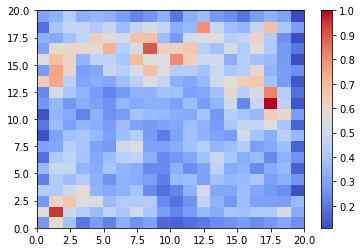

In [5]:
plt.figure(figsize=(6,4))
plt.pcolor(som1.distance_map().T, cmap='coolwarm')
plt.colorbar()
plt.show()

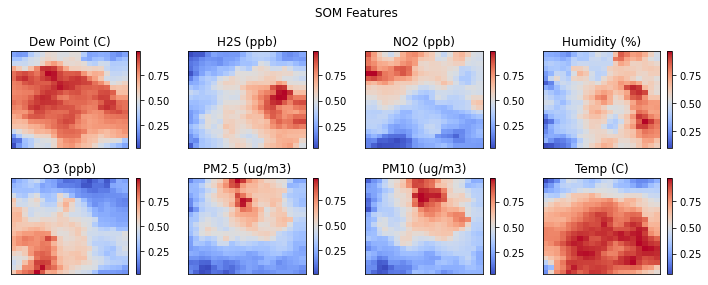

In [6]:
W = som1.get_weights()
plt.figure(figsize=(10,4))
for i, f in enumerate(df_raw.columns.to_list()):
    plt.subplot(2,4, i+1)
    plt.title(f)
    plt.pcolor(W[:,:,i].T, cmap='coolwarm')
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])

plt.suptitle("SOM Features")
plt.tight_layout()
plt.savefig("Plots/SOM/features.png")
plt.show()

**Παρόμοια συμπεριφορά:**  Dew Point - Temp | PM2.5 - PM10

### Clustering

In [7]:
n,m = 1,3
som = MiniSom(n, m, df_scaled.shape[1], sigma=0.5, learning_rate=0.5, random_seed=10)
som.train(df_scaled, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.5188285690869284


In [8]:
winner_coordinates = np.array([som.winner(x) for x in df_scaled]).T
cluster_index = np.ravel_multi_index(winner_coordinates, (n,m))

In [9]:
df_clustered = df_raw.copy()
df_clustered['cluster'] = cluster_index
profiles = df_clustered.drop(columns=['Dew Point (C)','Temp (C)','Humidity (%)'])
profiles.head()

,H2S (ppb),NO2 (ppb),O3 (ppb),PM2.5 (ug/m3),PM10 (ug/m3),cluster
Datetime,,,,,,
2022-04-10,6.988750,52.842917,23.745833,4.959583,7.960417,0
2022-04-11,0.655833,36.071667,48.096250,4.507917,6.797083,0
2022-04-12,5.760000,34.426250,36.747917,3.970417,6.434167,0
2022-04-13,4.475417,53.863333,28.420000,5.264167,8.139167,0
2022-04-14,7.202500,60.392917,23.560000,9.464583,13.055417,2


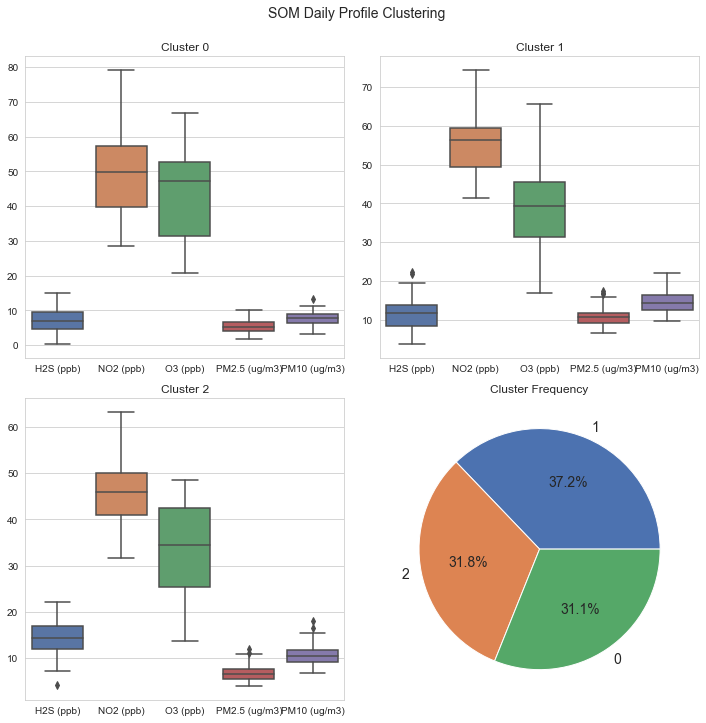

In [15]:
sns.set_style('whitegrid')
sns.set_palette("deep")
fig, ax = plt.subplots(2,2, figsize=(10,10))

sns.boxplot(data=profiles.loc[df_clustered['cluster']==0].drop(columns='cluster'), ax=ax[0,0])
sns.boxplot(data=profiles.loc[df_clustered['cluster']==1].drop(columns='cluster'), ax=ax[0,1])
sns.boxplot(data=profiles.loc[df_clustered['cluster']==2].drop(columns='cluster'), ax=ax[1,0])
df_clustered['cluster'].value_counts().plot(kind='pie',autopct='%1.1f%%', fontsize=14, ax=ax[1,1])

ax[0,0].set_title('Cluster 0')
ax[0,1].set_title('Cluster 1')
ax[1,0].set_title('Cluster 2')
ax[1,1].set_title('Cluster Frequency')
ax[1,1].set_ylabel("")

plt.suptitle("SOM Daily Profile Clustering", y=1, fontsize=14)
plt.tight_layout()
plt.savefig("Plots/SOM/clustering.png")
plt.show()